# Imports

from Bio import Entrez
import time


In [2]:
%pip install biopython


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install symspellpy


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
#import kagglehub
import os
import shutil
import pandas as pd

import numpy as np
from symspellpy.symspellpy import SymSpell, Verbosity

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer


from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from gensim import corpora
from gensim.models import LdaModel



In [6]:
from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from gensim import corpora
from gensim.models import LdaModel

In [7]:
from backports import tarfile

In [8]:
import pkg_resources

/var/folders/zv/4f9cw9vs6tjbvz5bh2k07w_40000gn/T/ipykernel_94560/1894539248.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [9]:
from Bio import Entrez
import time
import xml.etree.ElementTree as ET

import pandas as pd
from datetime import datetime
import numpy as np


# Get articles from PubMed

In [10]:
Entrez.email = "gracefujinaga@gmail.com"

def get_ids(query, num_ids=10000, batch_size=500, delay=0.5):
    ids = []
    for start in range(0, num_ids, batch_size):
        handle = Entrez.esearch(
            db="pubmed",
            term=query,
            retstart=start,
            retmax=batch_size,
        )
        record = Entrez.read(handle)
        ids.extend(record["IdList"])
        time.sleep(delay)

        # stop early if we need to
        if len(record["IdList"]) < batch_size:
            break

    print(f"Retrieved {len(ids)} IDs")
    return ids


In [11]:
ids = get_ids('erectile dysfunction')

Retrieved 9999 IDs


In [12]:
id_df = pd.DataFrame(ids, columns=['article_id'])

id_df.to_csv('/Users/gracefujinaga/womens_health/data/ed_id_dataframe.csv')

In [13]:
from bs4 import BeautifulSoup

def parse_mesh_list(mesh_list_obj):
    # If it's a list like in your example:
    return [str(el) for el in mesh_list_obj[0]]

In [14]:
from Bio import Entrez
from time import sleep
import xml.etree.ElementTree as ET


def fetch_pubmed_metadata(id_list, batch_size=100, delay=0.4):
    results = []

    for i in range(0, len(id_list), batch_size):
        batch_ids = id_list[i:i + batch_size]
        handle = Entrez.efetch(db="pubmed", id=','.join(batch_ids), retmode="xml")
        records = Entrez.read(handle)

        for article in records['PubmedArticle']:
            article_data = {}

            # Title
            title = article['MedlineCitation']['Article'].get('ArticleTitle', 'No title')

            # Abstract
            abstract = article['MedlineCitation']['Article'].get('Abstract', {}).get('AbstractText', ['No abstract'])
            abstract_text = ' '.join(str(a) for a in abstract)

            # Authors
            author_list = article['MedlineCitation']['Article'].get('AuthorList', [])
            authors = []
            for a in author_list:
                lastname = a.get('LastName', '')
                firstname = a.get('ForeName', '')
                if lastname or firstname:
                    authors.append(f"{firstname} {lastname}".strip())
            authors_text = '; '.join(authors) if authors else "No authors"

            # Journal / Publisher
            journal = article['MedlineCitation']['Article']['Journal'].get('Title', 'No journal')

            # Date of Publication
            pub_date = article['MedlineCitation']['Article']['Journal']['JournalIssue'].get('PubDate', {})
            year = pub_date.get('Year', '')
            month = pub_date.get('Month', '')
            day = pub_date.get('Day', '')
            pub_date_formatted = f"{year}-{month}-{day}".strip('-')

            # key words - list of words
            try:
                keywords = parse_mesh_list(article['MedlineCitation']['KeywordList'])
            except:
                keywords = None

            # get id
            pmid = article['MedlineCitation']['PMID']
            article_data['pmid'] = str(pmid)

            article_data['title'] = title
            article_data['keywords'] = keywords
            article_data['abstract'] = abstract_text
            article_data['authors'] = authors_text
            article_data['journal'] = journal
            article_data['pub_date'] = pub_date_formatted

            results.append(article_data)

        time.sleep(delay) 
    return results


In [15]:
ed_article_metadata = fetch_pubmed_metadata(ids)

In [16]:
len(ed_article_metadata)

9967

In [17]:
df = pd.DataFrame(ed_article_metadata)

In [18]:
df.to_csv('data/ed_article_data.csv', index=False)

In [19]:
df.iloc[-1]

pmid                                               26429202
title       Gout and Association with Erectile Dysfunction.
keywords                                               None
abstract                                        No abstract
authors                                      Allan C Gelber
journal                         The Journal of rheumatology
pub_date                                           2015-Oct
Name: 9966, dtype: object

# MORE DATA

In [86]:
with open("/Users/gracefujinaga/womens_health/data/menopause_ids.txt") as f:
    id_list = [line.strip() for line in f if line.strip()]

In [87]:
len(id_list)

100606

In [22]:
menopause_article_metadata = fetch_pubmed_metadata(id_list, 1000, 0.5)

In [23]:
df = pd.DataFrame(menopause_article_metadata)

In [24]:
df.to_csv('/Users/gracefujinaga/womens_health/data/all_menopause_data.csv')

# EDA

In [88]:
df = pd.read_csv('data/all_menopause_data.csv')

In [89]:
df.head()

,Unnamed: 0,pmid,title,keywords,abstract,authors,journal,pub_date
0,0,1697,Treatment of ovarian hyperstimulation syndrome...,NaN,Ovarian hyperstimulation was produced by human...,R Z Gergely; E Paldi; Y Erlik; A Makler,Obstetrics and gynecology,1976-Jan
1,1,2274,Circulating levels of prolactin in human breas...,NaN,Serum prolactin concentrations were measured b...,N A Sheth; K J Ranadive; J N Suraiya; A R Sheth,British journal of cancer,1975-Aug
2,2,2401,Experience with a simple method for estrogen r...,NaN,A simple procedure for the assay of specific e...,L Liskowski; D P Rose,Clinica chimica acta; international journal of...,1976-Mar-01
3,3,4380,Age at the menopause and onset of the climacte...,NaN,"In this study, 6877 women were analysed whose ...",V Magurský; M Mesko; L Sokolík,International journal of fertility,1975
4,4,6351,"Effect of hysterectomy, oophorectomy and estro...",NaN,No abstract,W H Utian,International journal of gynaecology and obste...,1975


In [90]:
df.dtypes

Unnamed: 0     int64
pmid           int64
title         object
keywords      object
abstract      object
authors       object
journal       object
pub_date      object
dtype: object

## Data Cleaning

### Convert to Date

In [91]:
df['pub_date']

0            1976-Jan
1            1975-Aug
2         1976-Mar-01
3                1975
4                1975
             ...     
100478    2025-May-02
100479           2025
100480       2025-Mar
100481    2025-Apr-23
100482    2025-May-02
Name: pub_date, Length: 100483, dtype: object

In [92]:
# date formats
date_formats = [
    "%Y-%b-%d",  # 2025-Apr-22
    "%Y-%b",     # 2022-Sep
    "%Y",        # 2023
]

# parse different formats
def parse_date(date_str):
    if pd.isna(date_str):
        return pd.NaT
    for fmt in date_formats:
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    return pd.NaT

# Apply the function
df['pub_date_parsed'] = df['pub_date'].apply(parse_date)

In [93]:
print(df['pub_date_parsed'].isna().sum())

# results in 27 nat
df[df['pub_date_parsed'].isna()]

284


,Unnamed: 0,pmid,title,keywords,abstract,authors,journal,pub_date,pub_date_parsed
65,65,60992,Endocrine and metabolic indices during progest...,NaN,Quingestanol at 300 y/day was well tolerated d...,T S Danowski; J H Sunder; S Nolan; T Stephan; ...,Behavioral neuropsychiatry,NaN,NaT
362,362,220722,[Current research in therapy of postmenopausal...,NaN,The goals of osteoporosis treatment are not on...,C Laroche; M Detilleux; D Sereni,La semaine des hopitaux : organe fonde par l'A...,NaN,NaT
749,749,459064,The myth of involutional melancholia.,NaN,Depressions occurring in the menopausal years ...,M M Weissman,JAMA,NaN,NaT
802,802,481761,[Evaluation of survival in a sample of patient...,NaN,Survival and its modalities were studied in 40...,S Abeatici; G Sera; N Palestini,Minerva chirurgica,NaN,NaT
906,906,537468,The effect of acutely administered 2-hydroxyes...,NaN,No abstract,E Y Adashi; J Rakoff; W Divers; J Fishman; S S...,Life sciences,NaN,NaT
...,...,...,...,...,...,...,...,...,...
96939,96939,38717964,The Future for Women's and Gender-Related Heal...,NaN,This commentary examines the future of women's...,Komkwuan P Paruchabutr,The Journal of perinatal & neonatal nursing,NaN,NaT
97038,97038,38758262,ACNM's Commentary on the Midwifery Workforce i...,NaN,The American College of Nurse-Midwives (ACNM) ...,Heather Clarke; Karen Jefferson,The Journal of perinatal & neonatal nursing,NaN,NaT
97765,97765,39082616,Intrarater and Interrater Reliability of Quant...,NaN,Quantitative ultrasound (QUS) performed at the...,Cynthia J Watson; Matthew J de Ruig; Kent T Sa...,Journal of geriatric physical therapy (2001),NaN,NaT
97834,97834,39120136,Effect of Acupressure on Menopausal Symptoms a...,NaN,This study was conducted as a randomized contr...,Ahu Aksoy Can; Duygu Vefikuluçay Yilmaz,Holistic nursing practice,NaN,NaT


In [158]:
print(df['pub_date_parsed'].min())
print(df['pub_date_parsed'].max())

1870-10-22 00:00:00
2025-12-21 00:00:00


### Handle NaN values

In [94]:
df[df['title'].isna()]

,Unnamed: 0,pmid,title,keywords,abstract,authors,journal,pub_date,pub_date_parsed


In [95]:
df[df['abstract'].isna()]

,Unnamed: 0,pmid,title,keywords,abstract,authors,journal,pub_date,pub_date_parsed


In [96]:
df[df['journal'].isna()]

,Unnamed: 0,pmid,title,keywords,abstract,authors,journal,pub_date,pub_date_parsed


In [97]:
df[df['keywords'].isna()]

,Unnamed: 0,pmid,title,keywords,abstract,authors,journal,pub_date,pub_date_parsed
0,0,1697,Treatment of ovarian hyperstimulation syndrome...,NaN,Ovarian hyperstimulation was produced by human...,R Z Gergely; E Paldi; Y Erlik; A Makler,Obstetrics and gynecology,1976-Jan,1976-01-01
1,1,2274,Circulating levels of prolactin in human breas...,NaN,Serum prolactin concentrations were measured b...,N A Sheth; K J Ranadive; J N Suraiya; A R Sheth,British journal of cancer,1975-Aug,1975-08-01
2,2,2401,Experience with a simple method for estrogen r...,NaN,A simple procedure for the assay of specific e...,L Liskowski; D P Rose,Clinica chimica acta; international journal of...,1976-Mar-01,1976-03-01
3,3,4380,Age at the menopause and onset of the climacte...,NaN,"In this study, 6877 women were analysed whose ...",V Magurský; M Mesko; L Sokolík,International journal of fertility,1975,1975-01-01
4,4,6351,"Effect of hysterectomy, oophorectomy and estro...",NaN,No abstract,W H Utian,International journal of gynaecology and obste...,1975,1975-01-01
...,...,...,...,...,...,...,...,...,...
100437,100437,40297421,A cross-sectional analysis of the vaginal micr...,NaN,The human microbiota is implicated in the deve...,Marlyd E Mejia; Savannah Bowman; Jessica Lee; ...,medRxiv : the preprint server for health sciences,2025-Apr-13,2025-04-13
100440,100440,40298120,The AUA/SUFU/AUGS Guideline on Genitourinary S...,NaN,Genitourinary syndrome of menopause (GSM) desc...,Melissa R Kaufman; A Lenore Ackerman; Katherin...,The Journal of urology,2025-Apr-29,2025-04-29
100441,100441,40298171,Breast Cancer Risk Modification in Women with ...,NaN,There is limited information on whether establ...,Allison W Kurian; Elisha Hughes; Ryan Bernhise...,Cancer research communications,2025-May-01,2025-05-01
100462,100462,40306365,Menopause in Cystic Fibrosis: Special consider...,NaN,Cystic fibrosis (CF) is a multisystem autosoma...,Sarah Haroon; Crystal Cobb; Sandy Sufian; Raks...,Endocrine practice : official journal of the A...,2025-Apr-28,2025-04-28


From the above, we can see that the title and keywords columns are never Nan. We can also see that there is a huge amoutn of variation in the strings of titles, abstracts, and more, there will be a robust cleaning process. The original loading of the data may also need to be altered

### Cleaning the strings in the dataset
- convert to lowercase
- remove punctuation
- NOTE this is different than preparing the data for NLP steps, this is to ensure that when counting journal articles it is normalized

In [98]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

def clean_abstract(comment): 

    suggestions = sym_spell.lookup_compound(comment, max_edit_distance=2)

    for suggestion in suggestions:
        #print(suggestion.term)
        tokens = suggestion.term

    #split document into individual words
    tokens=tokens.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))

    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]

    # # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]

    # # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]

    #lowercase all words
    tokens = [word.lower() for word in tokens]

    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words_to_remove = ['menopause']
    
    tokens = [w for w in tokens if (not w in stop_words and not w in words_to_remove)]    

    # word stemming    
    ps=PorterStemmer()
    tokens=[ps.stem(word) for word in tokens]

    #print(tokens)
    return tokens


## Clean Journal

In [111]:

def clean_journal(comment): 
    suggestions = sym_spell.lookup_compound(comment, max_edit_distance=2)

    for suggestion in suggestions:
        tokens = suggestion.term

    # Split into individual words
    tokens = tokens.split()
    
    # Remove punctuation
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]

    # Remove tokens with numbers and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]

    # Filter out short words
    tokens = [word for word in tokens if len(word) > 4]

    # Lowercase all words
    tokens = [word.lower() for word in tokens]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]

    # Join tokens back into a cleaned string
    cleaned_text = ' '.join(tokens)

    return cleaned_text


# Apply the clean_comment function to the 'comment' column
df['journal_cleaned'] = df['journal'].apply(clean_journal)

# Compute comment lengths after cleaning
df['journal_length'] = df['journal_cleaned'].apply(len)

# Get statistics
average_length = df['journal_length'].mean()
max_length = df['journal_length'].max()
min_length = df['journal_length'].min()

# Display results
print(f"Average Length: {average_length}")
print(f"Max Length: {max_length}")
print(f"Min Length: {min_length}")

Average Length: 31.123802036165323
Max Length: 189
Min Length: 0


In [99]:
df.head()

,Unnamed: 0,pmid,title,keywords,abstract,authors,journal,pub_date,pub_date_parsed
0,0,1697,Treatment of ovarian hyperstimulation syndrome...,NaN,Ovarian hyperstimulation was produced by human...,R Z Gergely; E Paldi; Y Erlik; A Makler,Obstetrics and gynecology,1976-Jan,1976-01-01
1,1,2274,Circulating levels of prolactin in human breas...,NaN,Serum prolactin concentrations were measured b...,N A Sheth; K J Ranadive; J N Suraiya; A R Sheth,British journal of cancer,1975-Aug,1975-08-01
2,2,2401,Experience with a simple method for estrogen r...,NaN,A simple procedure for the assay of specific e...,L Liskowski; D P Rose,Clinica chimica acta; international journal of...,1976-Mar-01,1976-03-01
3,3,4380,Age at the menopause and onset of the climacte...,NaN,"In this study, 6877 women were analysed whose ...",V Magurský; M Mesko; L Sokolík,International journal of fertility,1975,1975-01-01
4,4,6351,"Effect of hysterectomy, oophorectomy and estro...",NaN,No abstract,W H Utian,International journal of gynaecology and obste...,1975,1975-01-01


#### Clean Abstract

In [112]:
# Apply the clean_comment function to the 'comment' column
df['abstract_cleaned'] = df['abstract'].apply(clean_abstract)

# Compute comment lengths after cleaning
df['abstract_length'] = df['abstract_cleaned'].apply(len)

# Get statistics
average_length = df['abstract_length'].mean()
max_length = df['abstract_length'].max()
min_length = df['abstract_length'].min()

# Display results
print(f"Average Length: {average_length}")
print(f"Max Length: {max_length}")
print(f"Min Length: {min_length}")

Average Length: 92.7769772001234
Max Length: 1108
Min Length: 1


In [164]:
df['abstract_cleaned_string'] = df['abstract_cleaned'].apply(lambda x: " ".join(x))

In [165]:
df.to_csv('/Users/gracefujinaga/womens_health/data/all_menopause_cleaned.csv')

## Exploring Data Range
- dates
- journals represented
- authors represented? --> a lot of cleaning required



In [113]:
df.head()

,Unnamed: 0,pmid,title,keywords,abstract,authors,journal,pub_date,pub_date_parsed,abstract_cleaned,abstract_length,year,journal_cleaned,journal_length
0,0,1697,Treatment of ovarian hyperstimulation syndrome...,NaN,Ovarian hyperstimulation was produced by human...,R Z Gergely; E Paldi; Y Erlik; A Makler,Obstetrics and gynecology,1976-Jan,1976-01-01,"[ovarian, hyper, stimul, produc, human, menopa...",33,1976.0,obstetrics gynaecology,22
1,1,2274,Circulating levels of prolactin in human breas...,NaN,Serum prolactin concentrations were measured b...,N A Sheth; K J Ranadive; J N Suraiya; A R Sheth,British journal of cancer,1975-Aug,1975-08-01,"[serum, prolactin, concentr, measur, radio, im...",45,1975.0,british journal cancer,22
2,2,2401,Experience with a simple method for estrogen r...,NaN,A simple procedure for the assay of specific e...,L Liskowski; D P Rose,Clinica chimica acta; international journal of...,1976-Mar-01,1976-03-01,"[simpl, procedur, assay, specif, oestrogen, re...",45,1976.0,clinical international journal clinical chemistry,49
3,3,4380,Age at the menopause and onset of the climacte...,NaN,"In this study, 6877 women were analysed whose ...",V Magurský; M Mesko; L Sokolík,International journal of fertility,1975,1975-01-01,"[studi, women, analys, whose, rang, artifici, ...",98,1975.0,international journal fertility,31
4,4,6351,"Effect of hysterectomy, oophorectomy and estro...",NaN,No abstract,W H Utian,International journal of gynaecology and obste...,1975,1975-01-01,[abstract],1,1975.0,international journal gynaecology obstetrics o...,107


#### Number of Articles over Time

In [127]:
print(f"date range: {df['pub_date_parsed'].min()} to {df['pub_date_parsed'].max()}")

date range: 1870-10-22 00:00:00 to 2025-12-21 00:00:00


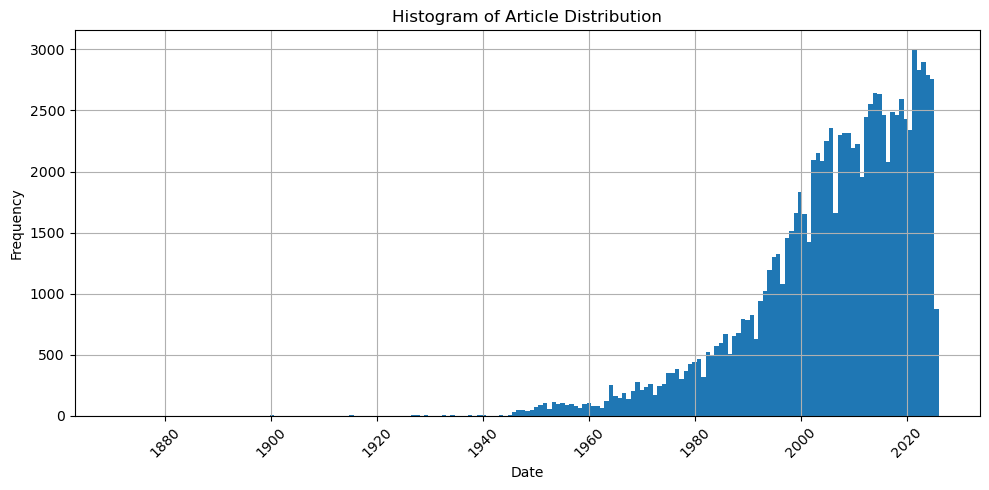

In [108]:
# Histogram of articles based on date
df['pub_date_parsed'].hist(bins='auto', figsize=(10, 5))
#plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2026-01-01'))
plt.title('Histogram of Article Distribution')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [104]:
len(df)

100483

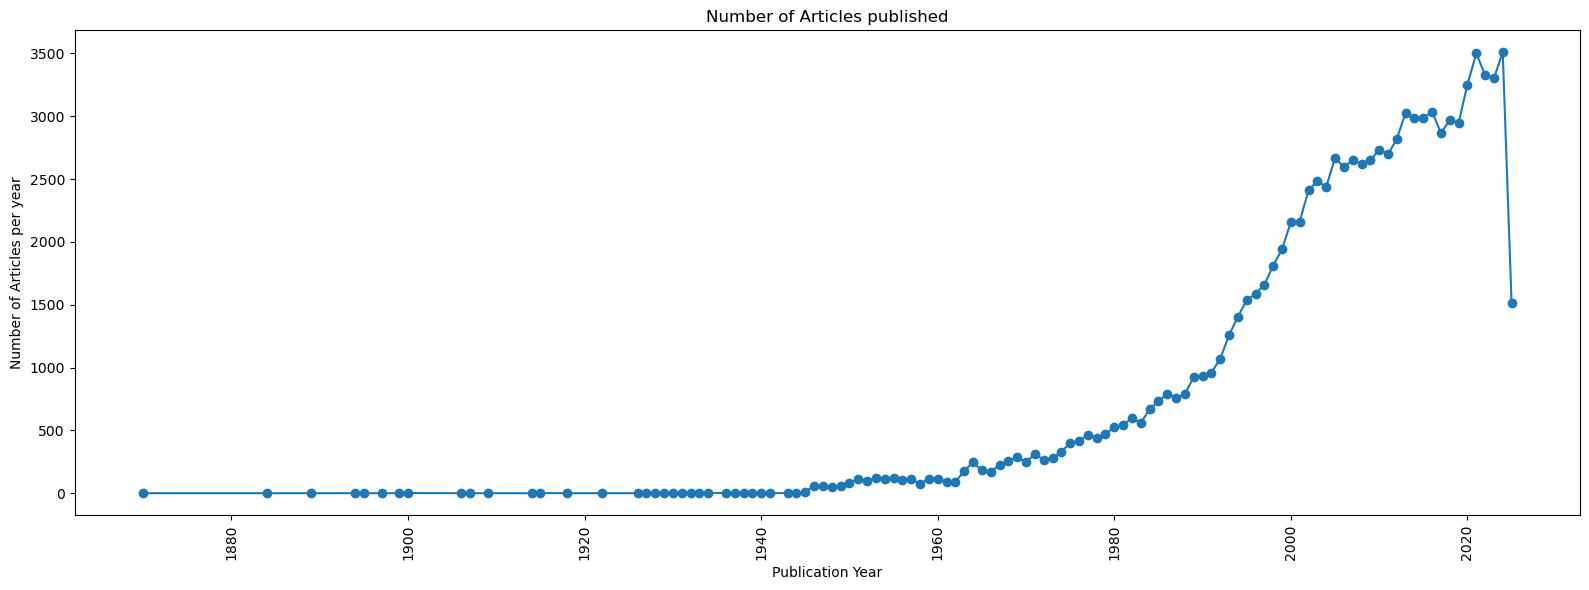

In [114]:
df['year'] = df['pub_date_parsed'].dt.year
articles_by_year = df.groupby('year')['pmid'].count().reset_index(name='count')

plt.figure(figsize=(16,6))
plt.plot(articles_by_year['year'], articles_by_year['count'], marker='o')

plt.xticks(rotation=90)

plt.xlabel('Publication Year')
plt.ylabel('Number of Articles per year')
plt.title('Number of Articles published')
plt.tight_layout()
plt.show()

#### Number of Articles per Journal

In [115]:
# group by journal
articles_by_journal = df.groupby('journal_cleaned')['pmid'].count().reset_index(name='count')

In [156]:
articles_by_journal

,journal_cleaned,count
2,abdominal radiology,7
3,abstracts,1
4,academia brasil science,4
5,academia laura model medicine laura,2
6,academia media,1
...,...,...
6012,zdravookhranenie belorussian,2
6013,zdravookhranenie kirghizia,1
6014,zealand medical journal,38
6015,zealand nursing journal,1


In [155]:
# drop the first row because that is title less
articles_by_journal = articles_by_journal[1:]

In [157]:
articles_by_journal.sort_values('count', ascending=False)

,journal_cleaned,count
4123,menopause,4563
3973,maturity,2875
1140,climacteric journal international menopause so...,1777
3036,journal clinical endocrinology metabolism,1507
2002,fertility sterility,1154
...,...,...
1830,european heart journal reports,1
1831,european heart journal supplements journal eur...,1
1832,european journal anaesthesiology,1
4256,monoclonal antibodies immune diagnosis immunot...,1


In [154]:
len(df)

len(articles_by_journal)

6016

In [119]:
print(f"range of articles: {articles_by_journal['count'].min()} to {articles_by_journal['count'].max()}")

range of articles: 1 to 4563


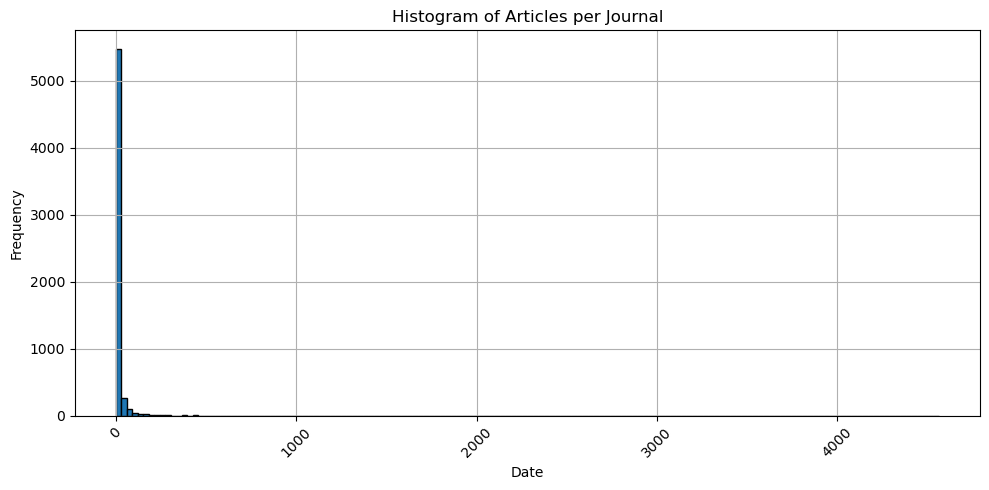

In [120]:
# plot
articles_by_journal['count'].hist(bins=150, figsize=(10, 5), edgecolor='black')
#plt.xlim((0,1000))
plt.title('Histogram of Articles per Journal')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

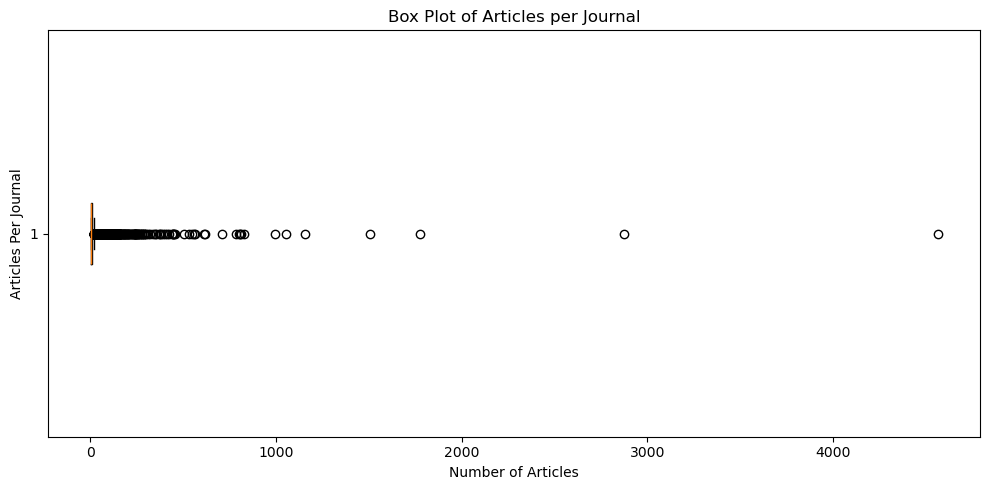

In [121]:

# Box plot
plt.figure(figsize=(10, 5))
plt.boxplot(articles_by_journal['count'], vert=False)
plt.title('Box Plot of Articles per Journal')
plt.xlabel('Number of Articles')
plt.ylabel('Articles Per Journal')
plt.tight_layout()
plt.show()


In [122]:
articles_by_journal.sort_values(by='count', ascending=False)

,journal_cleaned,count
4123,menopause,4563
3973,maturity,2875
1140,climacteric journal international menopause so...,1777
3036,journal clinical endocrinology metabolism,1507
2002,fertility sterility,1154
...,...,...
1829,european heart journal cardiovascular pharmacy...,1
1830,european heart journal reports,1
1831,european heart journal supplements journal eur...,1
4256,monoclonal antibodies immune diagnosis immunot...,1


# NLP Exploration
- get all of the keywords and cluster them
- cluster documents based on the abstract


In [56]:
from sklearn.cluster import KMeans

In [57]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [58]:
def cluster_embeddings(cluster_df, title, embeddings, n_clusters=2):

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(embeddings)

    clusters = kmeans.fit_predict(embeddings)

    # Create df
    cluster_df['Cluster'] = clusters
    cluster_df = cluster_df[['Cluster', 'title', 'abstract_cleaned_string']]

    # dimension reduction: TSNE
    reducer = TSNE(n_components=2, random_state=42, init = 'random')
    reduced_embeddings_tsne = reducer.fit_transform(embeddings)

    # dimension reduction: PCA
    reducer = PCA(n_components=2, random_state=42)
    reduced_embeddings_pca = reducer.fit_transform(embeddings)
    
    if (title == 'TFIDF') :
        fig, axes = plt.subplots(1, 3, figsize=(12, 5))

        sns.scatterplot(x=reduced_embeddings_tsne[:, 0], y=reduced_embeddings_tsne[:, 1], hue=kmeans_labels, palette="viridis", ax=axes[0])
        axes[0].set_title(f"{title}: KMeans with tsne")

        sns.scatterplot(x=reduced_embeddings_pca[:, 0], y=reduced_embeddings_pca[:, 1], hue=kmeans_labels, palette="coolwarm", ax=axes[1])
        axes[1].set_title(f"{title}: KMeans with pca")

        plt.show()

        return cluster_df


    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=kmeans_labels, palette="viridis", ax=axes[2])
    axes[2].set_title(f"{title}: KMeans No Reduction")

    sns.scatterplot(x=reduced_embeddings_tsne[:, 0], y=reduced_embeddings_tsne[:, 1], hue=kmeans_labels, palette="viridis", ax=axes[0])
    axes[0].set_title(f"{title}: KMeans with tsne")

    sns.scatterplot(x=reduced_embeddings_pca[:, 0], y=reduced_embeddings_pca[:, 1], hue=kmeans_labels, palette="coolwarm", ax=axes[1])
    axes[1].set_title(f"{title}: KMeans with pca")

    plt.show()

    return cluster_df



In [ ]:
df['text'] = df['text'].str.replace(r'\bmenopause\b', '', case=False, regex=True)

#### TFIDF

In [123]:
# todo: tf-idf --> means clustering
# LDA

# TFIDF
Tfidf=TfidfVectorizer(ngram_range=(1,1))
TFIDF_embeddings=Tfidf.fit_transform(df['abstract_cleaned_string'].tolist())     


tfidf_matrix_df=pd.DataFrame(TFIDF_embeddings.toarray(), columns=Tfidf.get_feature_names_out(), index=df['title'].tolist())

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


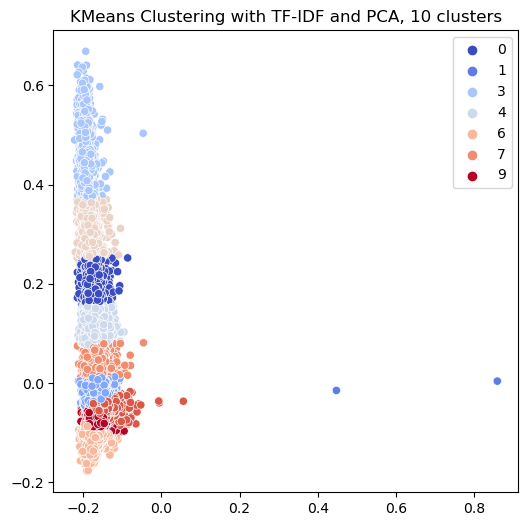

In [186]:
cluster_df = df.copy()

title = "TFIDF"
embeddings = TFIDF_embeddings

n_clusters=10

if True:

    # dimension reduction: PCA
    
    reducer = PCA(n_components=2, random_state=42)
    reduced_embeddings_pca = reducer.fit_transform(embeddings)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(reduced_embeddings_pca)

    plt.figure(figsize=(6, 6))
    ax = sns.scatterplot(x=reduced_embeddings_pca[:, 0], y=reduced_embeddings_pca[:, 1], hue=kmeans_labels, palette="coolwarm")
    ax.set_title(f"KMeans Clustering with TF-IDF and PCA, {n_clusters} clusters" )

    plt.show()

    # Create df
    cluster_df['Cluster'] = kmeans_labels
    cluster_df = cluster_df[['Cluster', 'title', 'abstract_cleaned_string']]


    # else:
    #     # Plotting
    #     fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    #     sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=kmeans_labels, palette="viridis", ax=axes[2])
    #     axes[2].set_title(f"{title}: KMeans No Reduction")

    #     sns.scatterplot(x=reduced_embeddings_tsne[:, 0], y=reduced_embeddings_tsne[:, 1], hue=kmeans_labels, palette="viridis", ax=axes[0])
    #     axes[0].set_title(f"{title}: KMeans with tsne")

    #     sns.scatterplot(x=reduced_embeddings_pca[:, 0], y=reduced_embeddings_pca[:, 1], hue=kmeans_labels, palette="coolwarm", ax=axes[1])
    #     axes[1].set_title(f"{title}: KMeans with pca")

    #     plt.show()


#cluster_embeddings(cluster_df, "tfidf", TFIDF_embeddings, n_clusters=2)

In [137]:
df['abstract_cleaned_string']
df['abstract_cleaned_string'] = df['abstract_cleaned_string'].str.replace(r'\bmenopaus\b', '', case=False, regex=True)

In [149]:
df.to_csv('/Users/gracefujinaga/womens_health/data/all_menopause_cleaned.csv', index=False)

In [151]:
# Function to remove "menopause" case-insensitively
def remove_menopause(word_list):
    return [word for word in word_list if word.lower() != "menopaus"]

def remove_studi_trial(word_list):
    return [word for word in word_list if (word.lower() != "trial" and word.lower() != "studi")]

# remove from cleand string
df['abstract_cleaned_string']
df['abstract_cleaned_string'] = df['abstract_cleaned_string'].str.replace(r'\bmenopaus\b', '', case=False, regex=True)

# Apply to the column
df['abstract_cleaned'] = df['abstract_cleaned'].apply(remove_menopause)
df['abstract_cleaned'] = df['abstract_cleaned'].apply(remove_studi_trial)

df['abstract_cleaned_string'] = df['abstract_cleaned'].apply(lambda x: " ".join(x))

df.to_csv('/Users/gracefujinaga/womens_health/data/all_menopause_cleaned.csv', index=False)

In [183]:
Tfidf = TfidfVectorizer(ngram_range=(1, 1))
TFIDF_embeddings = Tfidf.fit_transform(df['abstract_cleaned_string'].tolist())   

n_clusters = 4
reducer = PCA(n_components=2, random_state=42)
reduced_embeddings_pca = reducer.fit_transform(TFIDF_embeddings.toarray())  # PCA requires dense array

km = KMeans(n_clusters=n_clusters, random_state=42)
clusters = km.fit_predict(reduced_embeddings_pca)

terms = Tfidf.get_feature_names_out()
df['Cluster'] = clusters

Dictionary = {
    'Doc Name': df['title'],
    'Cluster': clusters,
    'Text': df['abstract_cleaned_string']
}
frame = pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name', 'Text'])

print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

terms_dict = []
cluster_terms = {}
cluster_title = {}

# Compute cosine distances for finding closest titles to each cluster center
df['Distance'] = cosine_distances(reduced_embeddings_pca, km.cluster_centers_)[np.arange(len(clusters)), clusters]

for i in range(n_clusters):
    print(f"\nCluster {i}:")
    temp_terms = []
    temp_titles = []


    # Top 5 titles closest to the cluster center
    print(f"\nTop 5 closest titles in Cluster {i}:")
    top_5 = df[df['Cluster'] == i].sort_values(by='Distance').head(5)
    for title in top_5['title']:
        print(f"  - {title}")

Top terms per cluster:

Cluster 0:

Top 5 closest titles in Cluster 0:
  - Invasive papillary carcinoma treated with neoadjuvant endocrine therapy in which pathological complete response was achieved.
  - Prognostic role of GPER/Ezrin in triple-negative breast cancer is associated with menopausal status.
  - Breastfeeding and breast cancer risk.
  - 21. The adjuvant treatment of breast cancer.
  - Tamoxifen-induced vasculitis.

Cluster 1:

Top 5 closest titles in Cluster 1:
  - Effect of hysterectomy, oophorectomy and estrogen therapy on libido.
  - Women's Health Initiative data--what were the real conclusions and how will these studies impact the pelvic floor?
  - Toremifene citrate (Fareston).
  - Get the facts straight.
  - Delayed benefit of mammography screening in premenopausal women.

Cluster 2:

Top 5 closest titles in Cluster 2:
  - Micronutrients intake and genetic variants associated with premature ovarian insufficiency; MASHAD cohort study.
  - The ageing ovary.
  - Bone m

#### LDA

In [64]:
from gensim import corpora
from gensim.models import LdaModel


In [188]:
from gensim import corpora
from gensim.models import LdaModel, TfidfModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt

num_topics = 10
processed_text = df['abstract_cleaned'].tolist()

# Create Dictionary and Corpus
dictionary = corpora.Dictionary(processed_text)
corpus = [dictionary.doc2bow(doc) for doc in processed_text]

# -------------------- LDA with Bag of Words
print(" -------------------- LDA with bag of words")
lda_bow = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=2)    

for idx, topic in lda_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

# -------------------- LDA with TFIDF
print(" -------------------- LDA with TFIDF")
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

lda_tfidf = LdaModel(corpus_tfidf, num_topics=num_topics, id2word=dictionary, passes=2)

for idx, topic in lda_tfidf.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

# -------------------- Visualization with pyLDAvis
print(" -------------------- Preparing pyLDAvis...")

pyLDAvis.enable_notebook()  # use enable_notebook() if you're in a Jupyter environment
vis_data = gensimvis.prepare(lda_tfidf, corpus_tfidf, dictionary)
pyLDAvis.display(vis_data)

# Optional: Save to HTML file if you're outside of Jupyter
# pyLDAvis.save_html(vis_data, 'lda_tfidf_vis.html')


 -------------------- LDA with bag of words
Topic: 0 
Words: 0.054*"women" + 0.045*"associ" + 0.028*"studi" + 0.019*"year" + 0.017*"factor" + 0.013*"among" + 0.012*"postmenopaus" + 0.012*"higher" + 0.010*"adjust" + 0.009*"model"
Topic: 1 
Words: 0.065*"group" + 0.032*"treatment" + 0.025*"effect" + 0.023*"women" + 0.022*"studi" + 0.019*"month" + 0.018*"control" + 0.016*"compar" + 0.015*"trial" + 0.015*"improv"
Topic: 2 
Words: 0.038*"ovarian" + 0.028*"reproduct" + 0.022*"pregnanc" + 0.018*"cycl" + 0.016*"menstrual" + 0.012*"femal" + 0.012*"fertil" + 0.010*"patient" + 0.009*"follicl" + 0.009*"human"
Topic: 3 
Words: 0.046*"oestrogen" + 0.030*"hormon" + 0.028*"level" + 0.024*"effect" + 0.018*"increas" + 0.017*"oestradiol" + 0.016*"activ" + 0.013*"ovariectomi" + 0.012*"induc" + 0.012*"femal"
Topic: 4 
Words: 0.036*"patient" + 0.022*"endometri" + 0.018*"vagin" + 0.013*"women" + 0.011*"surgeri" + 0.011*"malign" + 0.011*"uterin" + 0.011*"pelvic" + 0.010*"case" + 0.009*"cervic"
Topic: 5 
Words

In [187]:
pyLDAvis.save_html(vis_data, 'lda_tfidf_vis_10.html')